# Contents:
1. basic implementation ready for use
2. performance testing implementation - returns dictionary with results and execution times
3. data exploration <br>

To-do: Implement handling for single files.

# run_joern-scan basic implementation
The following implementation of joern-scan is designed to force new cpg generation by default. This behavior can be overridden by passing overwrite=false as the second parameter.<br>
First parameter: directory of files to be scanned. <br>
Second optional parameter: overwrite=Boolean (default=True). To let joern-scan query against a cache copy of the CPG if available, set to false. <br>
Output: Dictionary of result strings parsed from joern-scan ouput. If no vulnerability returns None. **Note:** Only the first vulnerability found in the scan's output will be returned. Later implementation may add the ability to account for multiple vulnerabilities, but return type may need reconsideration. <br>
Required libraries: os for directory navigation and subprocess to call joern-scan and handle output.

In [2]:
import os
import subprocess

def run_joern_scan(directory, overwrite=True):
    results = {}
    
    call_scan = ['joern-scan']
    
    # force joern-scan to generate a new cpg
    if overwrite:
        call_scan.append('--overwrite')

    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)

        if os.path.isfile(filepath):

            try:
                process = subprocess.run(
                    call_scan + [filepath],
                    stdout=subprocess.PIPE,
                    stderr=subprocess.PIPE,
                    text=True
                )

                output = process.stdout + process.stderr
                result_line = None
                for line in output.splitlines():
                    if line.startswith("Result:"):
                        result_line = line
                        break

                results[filename] = result_line

                
                print(f'processed {filename}: {result_line}')

            except Exception as e:
                print(f'error processing {filename}: {e}')
                results[filename] = {
                    'result': None,
                    'error': str(e)
                }
    return results

## An example call to the function:

In [4]:
code_path = "/home/a_prufrock/vuln_progs_and_patches/buggy_and_patched/codebase/"

scan_result = run_joern_scan(code_path)


processed fstring1_f.c: Result: 4.0 : Non-constant format string passed to printf/sprintf/vsprintf: fstring1_f.c:24:main
processed fstring3.c: Result: 4.0 : Non-constant format string passed to printf/sprintf/vsprintf: fstring3.c:37:open_whatever
processed boflow4_f.c: None
processed boflow2.c: Result: 8.0 : Dangerous function gets() used: boflow2.c:8:main
processed complex1_f.c: Result: 4.0 : Non-constant format string passed to printf/sprintf/vsprintf: complex1_f.c:24:main
processed boflow5.c: None
processed complex4.c: Result: 4.0 : Non-constant format string passed to printf/sprintf/vsprintf: complex4.c:24:processData
processed fstring2.c: Result: 4.0 : Non-constant format string passed to printf/sprintf/vsprintf: fstring2.c:18:read_file
processed boflow6_f.c: Result: 3.0 : Unchecked read/recv/malloc: boflow6_f.c:47:main
processed boflow1.c: Result: 8.0 : Dangerous function gets() used: boflow1.c:8:get_input
processed fstring4.c: Result: 3.0 : Unchecked read/recv/malloc: fstring4.c

# run_joern-scan performance implementation

The primary difference with this original implementation is that the overwrite flag is False by default instead. Also execution time is recorded for each query and included in the return dictionary for performance analysis.

In [1]:
import pandas as pd
import os
import subprocess
import time
import seaborn as sns
import matplotlib.pyplot as plt
# May need to install pandas, matplotlib, numpy
#Installing collected packages: tzdata, numpy, pandas
#Successfully installed numpy-1.24.4 pandas-2.0.3 tzdata-2025.1
code_vuln_path = "/home/a_prufrock/vuln_progs_and_patches/buggy_and_patched/codebase/"
code_fixd_path = "/home/a_prufrock/vuln_progs_and_patches/buggy_and_patched/patched_codes/"


In [4]:
!joern-scan

Writing logs to: /tmp/joern-scan-log.txt
Creates a code property graph and scans it with queries from installed bundles.
Version: `4.0.247`
Usage: joern-scan [options] [src]

  --help               Prints this usage text
  src                  source code directory to scan
  --overwrite          Overwrite CPG if it already exists
  --store              Store graph changes made by scanner
  --dump               Dump available queries to a file at `/tmp/querydb.json`
  --dump-to <value>    Dump available queries to a specific file
  --list-query-names   Print a list of available query names
  --updatedb           Update query database
  --dbversion <value>  Version of query database `updatedb`-operation installs
  --names <value>      Filter queries used for scanning by name, comma-separated string
  --tags <value>       Filter queries used for scanning by tags, comma-separated string
  --depth <value>      Set call depth for interprocedural analysis
  --language <value>   Source languag

In [12]:
results = {}

In [13]:
code_test_path = "/home/a_prufrock/vuln_progs_and_patches/buggy_and_patched/codebase/test/"

## Test run

In [15]:
for file in os.listdir(code_test_path):
    filepath = os.path.join(code_vuln_path, file)

    if os.path.isfile(filepath):

        time_start = time.perf_counter()
        try:
            process = subprocess.run(
                ['joern-scan', filepath],
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE,
                text=True
            )

            time_end = time.perf_counter()
            time_elapsed = time_end - time_start

            output = process.stdout + process.stderr
            result_line = None
            for line in output.splitlines():
                if line.startswith("Result:"):
                    if result_line != None: # lookout for multiple 'result_line's
                        print("more than one result found!")
                        print(f'result_line = {result_line}')
                        print(f'line = {line}')
                    else:
                        result_line = line

            results[file] = result_line

            print(f'processed {file}: {result_line}')

        except Exception as e:
            print(f'error processing {file}: {e}')
                        
    

processed boflow2.c: Result: 8.0 : Dangerous function gets() used: boflow2.c:8:main
processed boflow1.c: Result: 8.0 : Dangerous function gets() used: boflow1.c:8:get_input


## run_joern-scan function 

In [16]:
def run_joern_scan(directory, overwrite=False):
    results = {}
    call_scan = ['joern-scan']
    # force joern-scan to generate a new cpg
    if overwrite:
        call_scan.append('--overwrite')

    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)

        if os.path.isfile(filepath):

            time_start = time.perf_counter()
            try:
                process = subprocess.run(
                    call_scan + [filepath],
                    stdout=subprocess.PIPE,
                    stderr=subprocess.PIPE,
                    text=True
                )

                time_end = time.perf_counter()
                time_elapsed = time_end - time_start

                output = process.stdout + process.stderr
                result_line = None
                for line in output.splitlines():
                    if line.startswith("Result:"):
                        if result_line != None: # lookout for multiple 'result_line's
                            print("more than one result found!")
                            print(f'result_line = {result_line}')
                            print(f'line = {line}')
                        else:
                            result_line = line

                results[filename] = {
                    'result:': result_line,
                    'execution_time': time_elapsed
                }

                print(f'processed {filename} in {time_elapsed:.4f} seconds: {result_line}')

            except Exception as e:
                print(f'error processing {filename}: {e}')
                results[filename] = {
                    'result': None,
                    'execution-time': None,
                    'error': str(e)
                }
    return results

## Performance analysis initializes query against all directories in list:
1. Once for initialization
2. Four times to test queries against cached CPG
3. Four times to test queries against regenerated CPG <br>
Results added to pandas dataframe for analysis

In [36]:
all_results = []

for directory in [code_vuln_path, code_fixd_path]:
    
    for run in range(1, 10):
        print(f'scanning {directory}, run {run}')
        flag = True if run > 5 else False
        scan_result = run_joern_scan(directory, overwrite=flag)

        df = pd.DataFrame.from_dict(scan_result, orient='index')
        df['filename'] = df.index
        df['directory'] = directory
        df['run'] = run
        df['overwrite'] = flag
        all_results.append(df)

scanning /home/a_prufrock/vuln_progs_and_patches/buggy_and_patched/codebase/, run 1
processed fstring1_f.c in 8.4655 seconds: Result: 4.0 : Non-constant format string passed to printf/sprintf/vsprintf: fstring1_f.c:24:main
processed fstring3.c in 8.7365 seconds: Result: 4.0 : Non-constant format string passed to printf/sprintf/vsprintf: fstring3.c:37:open_whatever
processed boflow4_f.c in 8.7152 seconds: None
processed boflow2.c in 6.6017 seconds: Result: 8.0 : Dangerous function gets() used: boflow2.c:8:main
processed complex1_f.c in 8.6203 seconds: Result: 4.0 : Non-constant format string passed to printf/sprintf/vsprintf: complex1_f.c:24:main
processed boflow5.c in 8.5986 seconds: None
processed complex4.c in 8.4393 seconds: Result: 4.0 : Non-constant format string passed to printf/sprintf/vsprintf: complex4.c:24:processData
processed fstring2.c in 8.7143 seconds: Result: 4.0 : Non-constant format string passed to printf/sprintf/vsprintf: fstring2.c:18:read_file
processed boflow6_f.

In [38]:
df_all = pd.concat(all_results, ignore_index=True)

In [39]:
df_all

,result:,execution_time,filename,directory,run,overwrite
0,Result: 4.0 : Non-constant format string passe...,8.465496,fstring1_f.c,/home/a_prufrock/vuln_progs_and_patches/buggy_...,1,False
1,Result: 4.0 : Non-constant format string passe...,8.736459,fstring3.c,/home/a_prufrock/vuln_progs_and_patches/buggy_...,1,False
2,None,8.715246,boflow4_f.c,/home/a_prufrock/vuln_progs_and_patches/buggy_...,1,False
3,Result: 8.0 : Dangerous function gets() used: ...,6.601688,boflow2.c,/home/a_prufrock/vuln_progs_and_patches/buggy_...,1,False
4,Result: 4.0 : Non-constant format string passe...,8.620320,complex1_f.c,/home/a_prufrock/vuln_progs_and_patches/buggy_...,1,False
...,...,...,...,...,...,...
265,Result: 3.0 : Unchecked read/recv/malloc: fstr...,8.710734,fstring4.c,/home/a_prufrock/vuln_progs_and_patches/buggy_...,9,True
266,None,8.553428,boflow3_f.c,/home/a_prufrock/vuln_progs_and_patches/buggy_...,9,True
267,None,8.506269,complex3.c,/home/a_prufrock/vuln_progs_and_patches/buggy_...,9,True
268,None,8.582959,complex2.c,/home/a_prufrock/vuln_progs_and_patches/buggy_...,9,True


In [47]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   result:         116 non-null    object 
 1   execution_time  270 non-null    float64
 2   filename        270 non-null    object 
 3   directory       270 non-null    object 
 4   run             270 non-null    int64  
 5   overwrite       270 non-null    bool   
dtypes: bool(1), float64(1), int64(1), object(3)
memory usage: 10.9+ KB


In [46]:
df_all.describe()

,execution_time,run
count,270.000000,270.000000
mean,7.448155,5.000000
std,1.095147,2.586784
min,5.930501,1.000000
25%,6.300210,3.000000
50%,6.887924,5.000000
75%,8.549046,7.000000
max,8.859655,9.000000


## Saving and loading dataframe to csv file between sessions.

In [48]:
df_all.to_csv('all_results1.csv')

In [2]:
df_all = pd.read_csv('all_results1.csv')

In [3]:
# function labels runs based on initialization, cached, or regenerated CPG
def label_run(run):
    if run == 1:
        return 'Initialization'
    elif 2 <= run <= 5:
        return 'Cached'
    elif 6 <= run <= 9:
        return 'Generated'

## Copy dataframe before transformations

In [4]:
df_filt = df_all.copy()

In [5]:
df_filt['cpg'] = df_filt['run'].apply(label_run)
print(df_filt['cpg'].value_counts())

cpg
Cached            120
Generated         120
Initialization     30
Name: count, dtype: int64


In [6]:
# shorten filename to remove path
df_filt['directory'] = df_filt['directory'].apply(lambda x: os.path.basename(x.rstrip('/\\')))


In [7]:
group_summary = df_filt.groupby(['directory', 'cpg'])['execution_time'].describe()
print(group_summary)

                              count      mean       std       min       25%  \
directory     cpg                                                             
codebase      Cached           60.0  6.664577  0.110585  6.411382  6.588896   
              Generated        60.0  8.521584  0.138584  8.232416  8.434889   
              Initialization   15.0  8.307609  0.698466  6.601688  8.365076   
patched_codes Cached           60.0  6.166533  0.104997  5.930501  6.098273   
              Generated        60.0  8.543704  0.144255  8.210491  8.457013   
              Initialization   15.0  6.173600  0.072091  6.022955  6.131661   

                                   50%       75%       max  
directory     cpg                                           
codebase      Cached          6.667828  6.726849  6.900943  
              Generated       8.519154  8.635503  8.778645  
              Initialization  8.585591  8.667286  8.835847  
patched_codes Cached          6.159950  6.249363  6.382040  
 

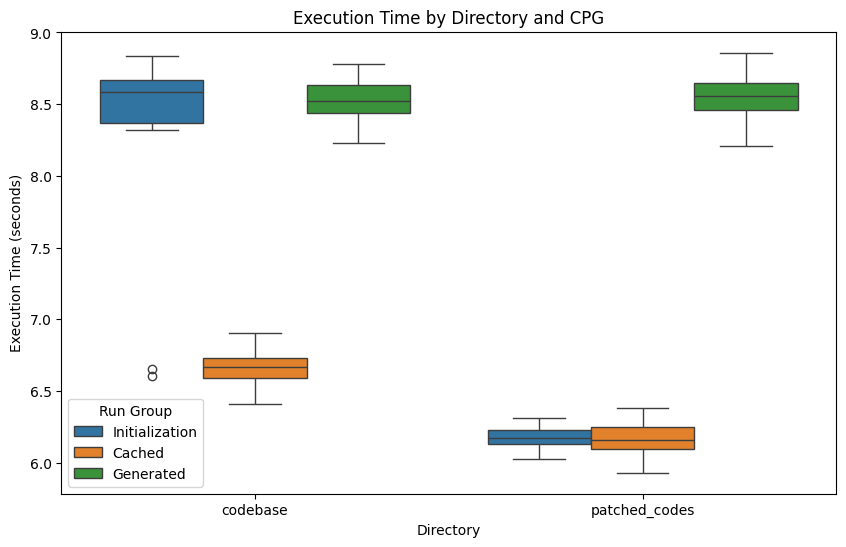

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='directory', y='execution_time', hue='cpg', data=df_filt)
plt.title('Execution Time by Directory and CPG')
plt.xlabel('Directory')
plt.ylabel('Execution Time (seconds)')
plt.legend(title='Run Group')
plt.show()

## Function to parse the vulnerability detection output
and create column for each segment

In [9]:
def parse_result_line(result_line):
    """
    Given a result line like:
    "Result: 3.0 : Unchecked read/recv/malloc: fstring4.c:36:main"
    
    This function returns a tuple with:
    (severity, type, filename, line, caller)
    
    If the format is unexpected, returns a tuple of Nones.
    """
    if not isinstance(result_line, str) or not result_line.startswith("Result:"):
        return (None, None, None, None, None)
    
    # Remove the "Result:" prefix and strip whitespace
    trimmed = result_line[len("Result:"):].strip()
    # Split on colons and strip each part
    parts = [part.strip() for part in trimmed.split(':')]
    
    # Check if we have at least 5 parts
    if len(parts) < 5:
        return (None, None, None, None, None)
    
    severity = parts[0]
    type_str = parts[1]
    filename = parts[2]
    line_number = parts[3]
    caller = parts[4]
    
    return (severity, type_str, filename, line_number, caller)

df_filt[['severity', 'type', 'filename', 'line', 'caller']] = df_filt['result:'].apply(
    lambda x: pd.Series(parse_result_line(x))
)

print(df_filt.head())


   Unnamed: 0                                            result:  \
0           0  Result: 4.0 : Non-constant format string passe...   
1           1  Result: 4.0 : Non-constant format string passe...   
2           2                                                NaN   
3           3  Result: 8.0 : Dangerous function gets() used: ...   
4           4  Result: 4.0 : Non-constant format string passe...   

   execution_time      filename directory  run  overwrite             cpg  \
0        8.465496  fstring1_f.c  codebase    1      False  Initialization   
1        8.736459    fstring3.c  codebase    1      False  Initialization   
2        8.715246          None  codebase    1      False  Initialization   
3        6.601688     boflow2.c  codebase    1      False  Initialization   
4        8.620320  complex1_f.c  codebase    1      False  Initialization   

  severity                                               type  line  \
0      4.0  Non-constant format string passed to printf/s

# Draft data exploration and analysis continues.
Continue at your own risk. Quality of code and notes not guaranteed.

In [10]:
unique_types = df_filt['type'].unique()
print(unique_types)

['Non-constant format string passed to printf/sprintf/vsprintf' None
 'Dangerous function gets() used' 'Unchecked read/recv/malloc']


In [11]:
group_counts = df_filt.groupby('cpg')['type'].value_counts()

print(group_counts)

cpg             type                                                        
Cached          Non-constant format string passed to printf/sprintf/vsprintf    28
                Dangerous function gets() used                                  12
                Unchecked read/recv/malloc                                       8
Generated       Non-constant format string passed to printf/sprintf/vsprintf    28
                Unchecked read/recv/malloc                                      16
                Dangerous function gets() used                                  12
Initialization  Non-constant format string passed to printf/sprintf/vsprintf     7
                Dangerous function gets() used                                   3
                Unchecked read/recv/malloc                                       2
Name: count, dtype: int64


In [12]:
counts_by_run = df_filt.groupby('run')['type'].value_counts()

print(counts_by_run)

run  type                                                        
1    Non-constant format string passed to printf/sprintf/vsprintf    7
     Dangerous function gets() used                                  3
     Unchecked read/recv/malloc                                      2
2    Non-constant format string passed to printf/sprintf/vsprintf    7
     Dangerous function gets() used                                  3
     Unchecked read/recv/malloc                                      2
3    Non-constant format string passed to printf/sprintf/vsprintf    7
     Dangerous function gets() used                                  3
     Unchecked read/recv/malloc                                      2
4    Non-constant format string passed to printf/sprintf/vsprintf    7
     Dangerous function gets() used                                  3
     Unchecked read/recv/malloc                                      2
5    Non-constant format string passed to printf/sprintf/vsprintf    7
     Danger

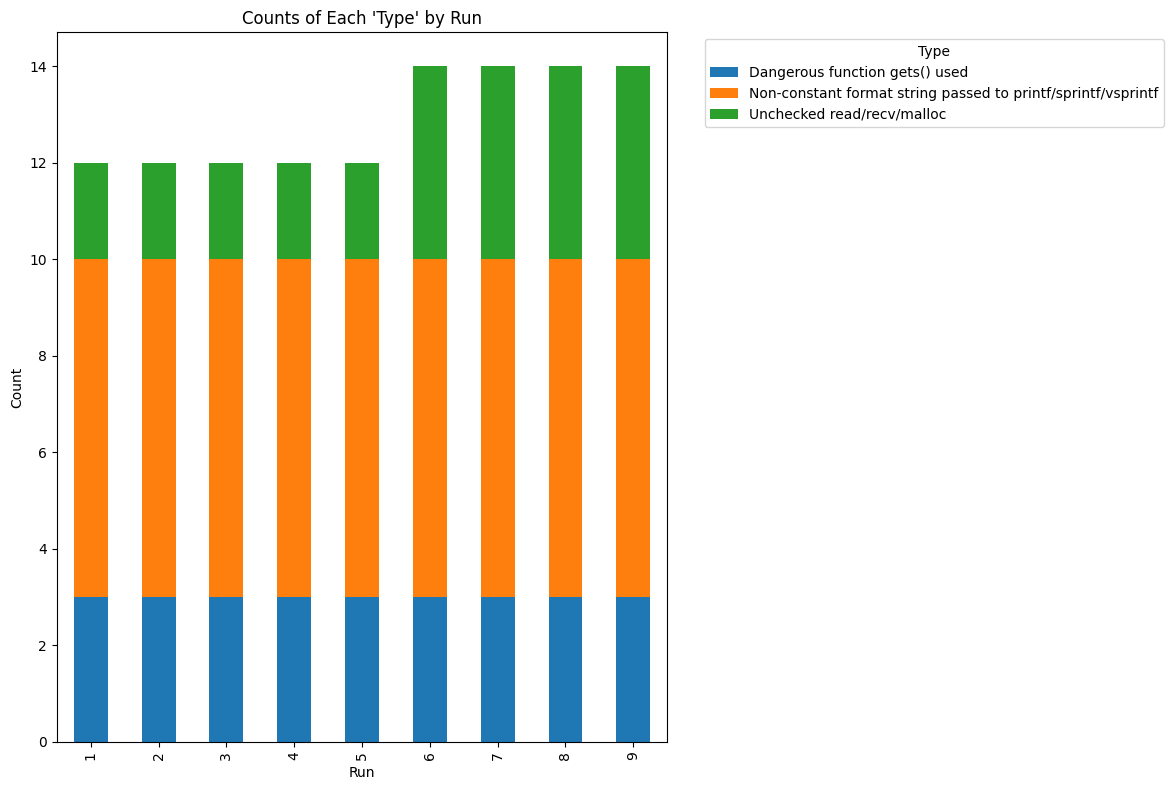

In [13]:
counts_df = df_filt.groupby('run')['type'].value_counts().unstack(fill_value=0)

# Create a stacked bar chart
counts_df.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.title("Counts of Each 'Type' by Run")
plt.xlabel("Run")
plt.ylabel("Count")
plt.legend(title="Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

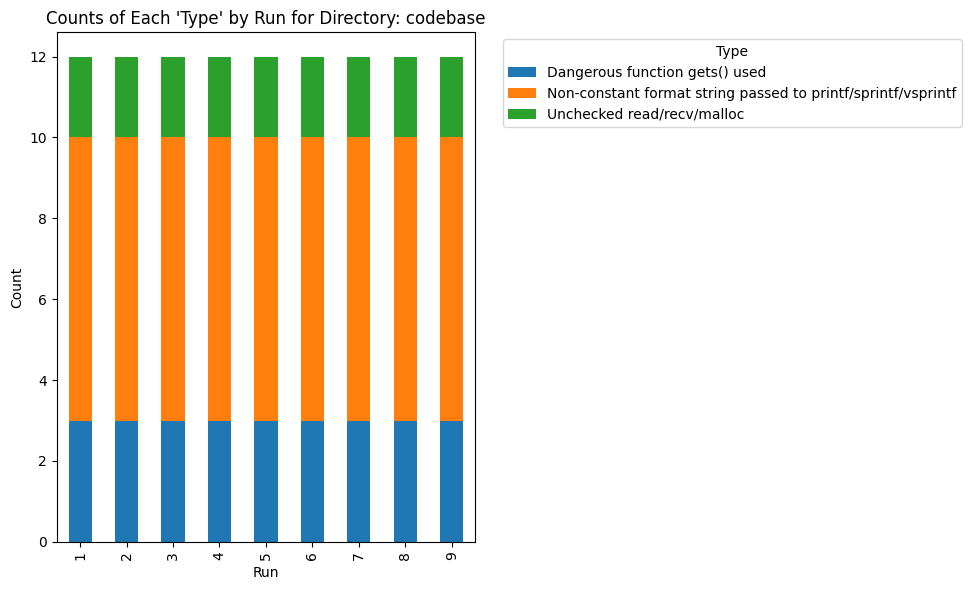

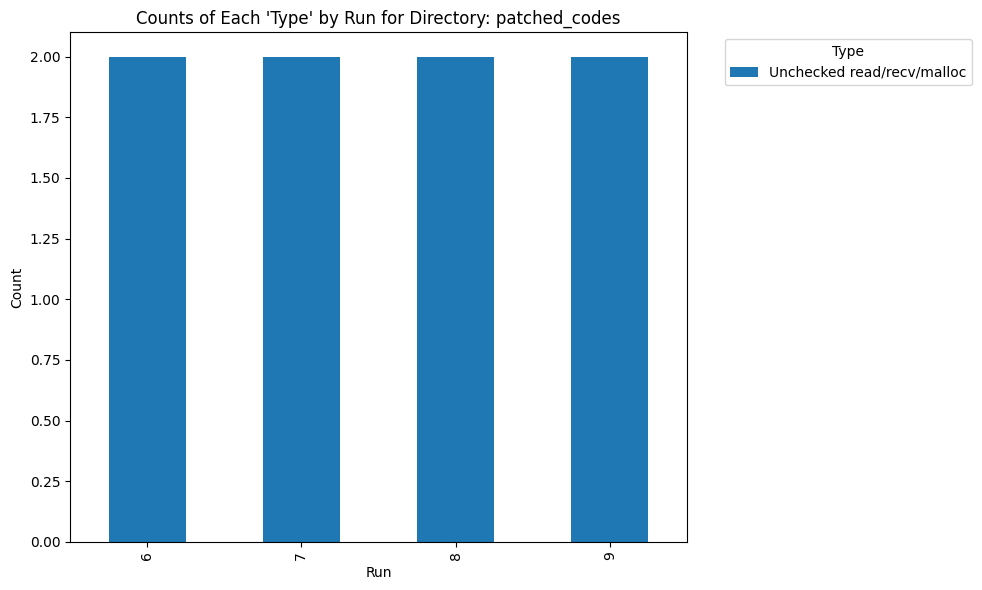

In [14]:
# Get unique directories
directories = df_filt['directory'].unique()

for d in directories:
    # Filter the DataFrame for the current directory
    df_sub = df_filt[df_filt['directory'] == d]
    
    # Group by 'run' and count the unique values in 'type'
    counts_df = df_sub.groupby('run')['type'].value_counts().unstack(fill_value=0)
    
    # Plot a stacked bar chart for this directory
    ax = counts_df.plot(kind='bar', stacked=True, figsize=(10, 6))
    ax.set_title(f"Counts of Each 'Type' by Run for Directory: {d}")
    ax.set_xlabel("Run")
    ax.set_ylabel("Count")
    plt.legend(title="Type", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [15]:
for filename, group in df_filt.groupby('filename'):
    unique_types = group['type'].unique()
    print(f"{filename}: {unique_types}")

boflow1.c: ['Dangerous function gets() used']
boflow2.c: ['Dangerous function gets() used']
boflow3_f.c: ['Dangerous function gets() used']
boflow6_f.c: ['Unchecked read/recv/malloc']
complex1_f.c: ['Non-constant format string passed to printf/sprintf/vsprintf']
complex2.c: ['Non-constant format string passed to printf/sprintf/vsprintf']
complex3.c: ['Non-constant format string passed to printf/sprintf/vsprintf']
complex4.c: ['Non-constant format string passed to printf/sprintf/vsprintf']
fstring1_f.c: ['Non-constant format string passed to printf/sprintf/vsprintf']
fstring2.c: ['Non-constant format string passed to printf/sprintf/vsprintf']
fstring3.c: ['Non-constant format string passed to printf/sprintf/vsprintf']
fstring4.c: ['Unchecked read/recv/malloc']


In [16]:
filenames_with_none = df_filt[df_filt['type'].isnull()]['filename'].unique()

# Print each filename
for filename in filenames_with_none:
    print(filename)

None


In [17]:
for (directory, filename), group in df_filt.groupby(['directory', 'filename']):
    # Count unique 'type' values while considering NaNs as a unique value.
    if group['type'].nunique(dropna=False) > 1:
        unique_types = group['type'].unique()
        print(f"Directory: {directory} | File: {filename} has multiple type values: {unique_types}")


In [20]:
time_elapsed_group = df_filt.groupby('cpg')['execution_time'].sum()
print(time_elapsed_group)

cpg
Cached             769.866564
Generated         1023.917286
Initialization     217.218129
Name: execution_time, dtype: float64


In [22]:
time_elapsed_run = df_filt.groupby(['cpg', 'run'])['execution_time'].sum().unstack(fill_value=0)
print(time_elapsed_run)

run                      1           2           3           4           5  \
cpg                                                                          
Cached            0.000000  192.037001  191.969954  193.289855  192.569754   
Generated         0.000000    0.000000    0.000000    0.000000    0.000000   
Initialization  217.218129    0.000000    0.000000    0.000000    0.000000   

run                      6           7           8           9  
cpg                                                             
Cached            0.000000    0.000000    0.000000    0.000000  
Generated       255.935532  256.250654  256.362522  255.368579  
Initialization    0.000000    0.000000    0.000000    0.000000  


In [27]:
def run_joern_scan_tag(directory, overwrite=False):
    results = {}
    call_scan = ['joern-scan']
    # force joern-scan to generate a new cpg
    if overwrite:
        call_scan.append('--overwrite')

    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)

        if os.path.isfile(filepath):

            time_start = time.perf_counter()
            try:
                process = subprocess.run(
                    call_scan + [filepath, '--tags', 'badfn'],
                    stdout=subprocess.PIPE,
                    stderr=subprocess.PIPE,
                    text=True
                )

                time_end = time.perf_counter()
                time_elapsed = time_end - time_start

                output = process.stdout + process.stderr
                result_line = None
                for line in output.splitlines():
                    if line.startswith("Result:"):
                        if result_line != None: # lookout for multiple 'result_line's
                            print("more than one result found!")
                            print(f'result_line = {result_line}')
                            print(f'line = {line}')
                        else:
                            result_line = line

                results[filename] = {
                    'result:': result_line,
                    'execution_time': time_elapsed
                }

                print(f'processed {filename} in {time_elapsed:.4f} seconds: {result_line}')

            except Exception as e:
                print(f'error processing {filename}: {e}')
                results[filename] = {
                    'result': None,
                    'execution-time': None,
                    'error': str(e)
                }
    return results

In [28]:
all_results = []

for directory in [code_vuln_path, code_fixd_path]:
    
    for run in range(1, 10):
        print(f'scanning {directory}, run {run}')
        flag = True if run > 5 else False
        scan_result = run_joern_scan_tag(directory, overwrite=flag)

        df = pd.DataFrame.from_dict(scan_result, orient='index')
        df['filename'] = df.index
        df['directory'] = directory
        df['run'] = run
        df['overwrite'] = flag
        all_results.append(df)

scanning /home/a_prufrock/vuln_progs_and_patches/buggy_and_patched/codebase/, run 1
processed fstring1_f.c in 6.6422 seconds: Result: 4.0 : Non-constant format string passed to printf/sprintf/vsprintf: fstring1_f.c:24:main
processed fstring3.c in 6.6806 seconds: Result: 4.0 : Non-constant format string passed to printf/sprintf/vsprintf: fstring3.c:37:open_whatever
processed boflow4_f.c in 6.4642 seconds: None
processed boflow2.c in 6.6152 seconds: Result: 8.0 : Dangerous function gets() used: boflow2.c:8:main
processed complex1_f.c in 6.7241 seconds: Result: 4.0 : Non-constant format string passed to printf/sprintf/vsprintf: complex1_f.c:24:main
processed boflow5.c in 6.6107 seconds: None
processed complex4.c in 6.6016 seconds: Result: 4.0 : Non-constant format string passed to printf/sprintf/vsprintf: complex4.c:24:processData
processed fstring2.c in 6.6978 seconds: Result: 4.0 : Non-constant format string passed to printf/sprintf/vsprintf: fstring2.c:18:read_file
processed boflow6_f.

KeyboardInterrupt: 

# Test 2 - no Result: problem *fixed on test 3 magically*
When running joern-scan on previously scanned files, the vulnerability is either not detected, or the Result is not being returned/printed.

In [19]:
results_test1 = run_joern_scan(code_test_path, overwrite=False)

processed boflow2.c in 6.2202 seconds: None
processed boflow1.c in 6.0251 seconds: None


In [20]:
results_test2 = run_joern_scan(code_test_path, overwrite=True)

processed boflow2.c in 8.5434 seconds: Result: 8.0 : Dangerous function gets() used: boflow2.c:8:main
processed boflow1.c in 8.4681 seconds: Result: 8.0 : Dangerous function gets() used: boflow1.c:8:get_input


In [25]:
results_test3 = run_joern_scan(code_test_path, overwrite=False)

processed boflow2.c in 6.4647 seconds: Result: 8.0 : Dangerous function gets() used: boflow2.c:8:main
processed boflow1.c in 6.6304 seconds: Result: 8.0 : Dangerous function gets() used: boflow1.c:8:get_input


In [24]:
print(results_test1)

{'boflow2.c': {'result:': None, 'execution_time': 6.220168379950337}, 'boflow1.c': {'result:': None, 'execution_time': 6.025086741021369}}
